# 4 Training and Modeling Data<a id='4_Training_and_Modeling_Data'></a>

## Contents <a id ="Content" > </a>

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Train Test Split](#Train_Test_Split) 
* [Training and Modeling](#Training_and_Modeling)
    * [Model Selection](#Model_Selection)
    * [Evaluation Metrics](#Evaluation-Metrics)
        * [Training and Modeling](#Train_and_Model)
        * [Hyperparameter Tuning and Model Training](#Hyperparameter_Tuning_Training)
            * [Logistic Regression](#Logistic_Regression)
            * [Evaluation](#Evaluation)
* [Additional Models](#AdditionalModels)
* [Summary](#Summary)
* [Recommendations](#Recom)

## Introduction <a id = 'Introduction'></a>

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn import metrics
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model 

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
import matplotlib.pyplot as plt

# remove warning
#import warnings
#warnings.filterwarnings("ignore")


In [2]:
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

In [3]:
pd.__version__

'1.2.4'

In [4]:
X_train.shape,y_train.shape

((7088, 16), (7088, 1))

In [5]:
X_test.shape,y_test.shape

((3039, 16), (3039, 1))

In [6]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7088.0,-3.454018e-16,1.000071,-2.531322,-0.661337,-0.038008,0.709986,3.327966
Credit_Limit,7088.0,8.597793e+00,0.930669,7.271217,7.841395,8.418587,9.298671,10.449178
Total_Revolving_Bal,7088.0,9.103482e-01,0.638103,0.000000,0.248822,1.000000,1.396112,1.977219
Total_Trans_Amt,7088.0,8.167921e+00,0.656979,6.390241,7.674617,8.267449,8.468633,9.824661
Avg_Utilization_Ratio,7088.0,2.753070e-01,0.276635,0.000000,0.023000,0.175000,0.502000,0.999000
Gender_Encoded,7088.0,5.328725e-01,0.498953,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,7088.0,2.344949e+00,1.299597,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,7088.0,2.839306e+00,1.215114,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,7088.0,2.175226e+00,1.334986,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,7088.0,1.081546e+00,0.330233,1.000000,1.000000,1.000000,1.000000,4.000000


In [7]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3039.0,1.760867e-16,1.000165,-2.545475,-0.671517,-0.046864,0.702719,2.701607
Credit_Limit,3039.0,8.616519e+00,0.940983,7.271217,7.854381,8.432724,9.328701,10.449178
Total_Revolving_Bal,3039.0,9.134881e-01,0.640117,0.000000,0.349961,1.000000,1.401403,1.961808
Total_Trans_Amt,3039.0,8.157574e+00,0.648578,6.234411,7.682021,8.271293,8.453401,9.797849
Avg_Utilization_Ratio,3039.0,2.739293e-01,0.273522,0.000000,0.022500,0.177000,0.503500,0.994000
Gender_Encoded,3039.0,5.202369e-01,0.499673,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,3039.0,2.349128e+00,1.297511,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,3039.0,2.851925e+00,1.201185,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,3039.0,2.199079e+00,1.332057,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,3039.0,1.088516e+00,0.341929,1.000000,1.000000,1.000000,1.000000,4.000000


## Training and Modeling <a id=Training_and_Modeling ></a>

### Model Selection <a id=Model_Selection ></a>

### Training and Modeling <a id=Train_and_Model>

### Fit Model on Intercept (naive model)

In [8]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()

In [9]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [53]:
def threshhold_and_plot(y_test,target,n_points=50,plot=True):
    probs = np.linspace(0,1,n_points)
    #def make_thresh():
    precision = [metrics.precision_score(y_test,np.where(target > thresh,1,0)) for thresh in probs]
    recall = [metrics.recall_score(y_test,np.where(target > thresh,1,0)) for thresh in probs]
    f1 = [metrics.f1_score(y_test,np.where(target > thresh,1,0)) for thresh in probs]
       # return precision,recall,f1

    #precision,recall,f1 = make_thresh()
    if plot:
        plt.plot(probs,precision,label='precision')
        plt.plot(probs,recall,label='recall')
        plt.plot(probs,f1,label='f1')
        plt.title("Metrics at different threshold")
        plt.xlabel("Probability")
        plt.legend()
        return precision,recall,f1
    else:
        return precision,recall,f1
    
def max_thresh(score_vec):
    max_idx=np.argmax(score_vec)
    max_score=score_vec[max_idx]
    return max_idx,max_score

In [11]:
null_reg = linear_model.LogisticRegression(fit_intercept= False,max_iter=500,random_state=632966)

In [12]:
X_train_null = np.ones(shape=y_train.shape[0]).reshape(-1,1)
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1,1)

In [13]:
#fit on train and test data no tuning
null_train = null_reg.fit(X=X_train_null,y=y_train)
null_test = null_reg.fit(X=X_test_null,y=y_test)

In [14]:
#predict_proba and pred_prob returns two columns, second one is target
train_pred = null_train.predict_proba(X_train_null)
test_pred = null_train.predict_proba(X_test_null)

In [15]:
#base metrics: minmum performance
metrics.precision_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0))
metrics.recall_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0))
metrics.f1_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0))

C:\Users\Chipmunk\anaconda3a\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [16]:
#check to see if close to population value
#print(f"Observed: {y_train.mean():.3f} Fit: {train_pred[:,1].mean(): .3f}")
print("Observed: {:.3f}, Fit: {:.3f}".format(y_train.mean(),train_pred[:,1].mean()))

Observed: 0.161, Fit: 0.161


In [17]:
model_params = {"model__C": (np.logspace(start=-4,stop=4,num=30))}

In [18]:
#pipe line has just model object
model_pipeline = pipeline.Pipeline(steps=[("model",null_reg)])

In [19]:
# set up cross-validator:
# 80/20 train/calibration split in this data (test data still held out)
# 200 iterations
# feel free to use another CV method and explain why
cross_validator = (
  model_selection.StratifiedShuffleSplit(train_size=0.8,
                                          random_state=1337,
                                          n_splits=50))

In [20]:
# set up grid search
model_grid = (
  model_selection.GridSearchCV(estimator=model_pipeline,
                           param_grid=model_params,
                           refit=True, # refit using best estimates
                           scoring="roc_auc", # metric to optimize (can pick another)
                           cv=cross_validator,
                           n_jobs = -1))

In [21]:
# fit model on intercept (random guesses - baseline performance)
null_mod = model_grid.fit(X_train_null,y_train)

In [22]:
cv_scores = (
  model_selection.cross_val_score(null_mod,
                                  X_train_null,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

In [23]:
cv_quantiles = np.quantile(a=cv_scores,q=[0.025,0.975])

In [24]:
print("Observed: {:.3f}".format(y_train.mean()))

Observed: 0.161


In [25]:
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.500,97.5%:0.500


<AxesSubplot:ylabel='Count'>

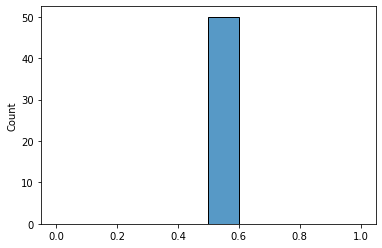

In [26]:
import seaborn as sns
sns.histplot(cv_scores, bins=10)

In [54]:
max_thresh(cv_scores)

(0, 0.5)

C:\Users\Chipmunk\anaconda3a\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chipmunk\anaconda3a\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chipmunk\anaconda3a\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chipmunk\anaconda3a\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

([0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.16057913787430075,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.27672242699177774,
  0.27672242699177774,
  0.27672242699177774,
  0.27672242699177774,
  0.27672242699177774,
  0.27672242699177774,
  0.27672242699177774,
  0.27672

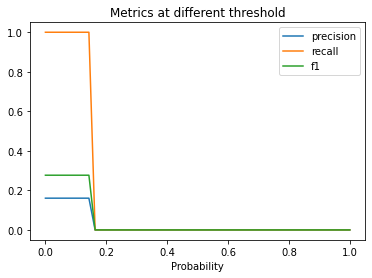

In [49]:
threshhold_and_plot(y_test,test_pred[:,1])

In [55]:
# check to see if close to population value
print(f"Observed: {y_train.mean():.3f} Fit: {train_pred[:,1].mean():.3f}")

Observed: 0.161 Fit: 0.161


## Additional Models: <a id=AdditionalModels></a>

## Summary <a id =Summary> </a>

## Recommendations <a id = Recom></a>